# Relative importance of boulder and lead towards combined score

The goal of this notebooks is to explore the question of whether one of the two combined climbing disciplines boulder or lead tends to have an outsize impact on combined ranking.

We hypothesize that there is some advantage to being a strong lead climber over strong boulderer.

This analysis builds on the work already done by [Kuba Główka](https://twitter.com/kuba_glowka/status/1690468469320417282)

In [131]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

pd.set_option('display.max_columns', 500)
sns.set(font_scale=2)

In [5]:
# Import the data from all boulder & lead combined events in 2022 and 2023
# (the only years in which this scoring has been used)

from pathlib import Path
csvs = Path('data/combined').glob('*.csv')

# Read each CSV file into DataFrame
# This creates a list of dataframes
dfs = []
for filename in csvs:
    dfs.append(pd.read_csv(filename))

# Concat the dfs into one big df
alldf = pd.concat(dfs)
alldf.sample(5)

,event_id,year,location,category,stage,athlete_id,name,combined_rank,combined_score,boulder_rank,boulder_score,lead_rank,lead_score
19,1301,2023,Bern,women,semi-final,1750,CONDIE Kyra,20.0,45.5,13.0,33.4,21.0,12.1
5,1234,2022,Morioka,women,final,2381,TANII Natsuki,6.0,97.3,8.0,29.2,5.0,68.1
14,1301,2023,Bern,women,semi-final,620,AVEZOU Zélia,15.0,73.3,11.0,34.3,15.0,39.0
1,1290,2022,Laval,men,semi-final,1274,Scherz Stefan,2.0,140.1,4.0,56,1.0,84.1
0,1290,2022,Laval,women,final,455,Janicot Hélène,1.0,178.0,3.0,78,1.0,100.0


## Sanity check

As a first step, lets confirm Kuba's average and std dev score numbers for the Bern event, to confirm data is correct and we're starting from the same place

In [150]:
bern_event_id=1301
bern_event = alldf[alldf['event_id'] == bern_event_id]

grouped = bern_event.groupby(['stage', 'category']).agg({'boulder_score':['mean',lambda x: x.std(ddof=0)], 'lead_score':['mean',lambda x: x.std(ddof=0)]}).round(2)
d = {'<lambda_0>':'std'}
grouped1 = grouped.rename(columns = d)
grouped1

boulder_score        lead_score       
                             mean    std       mean    std
stage      category                                       
final      men             84.025  10.67      61.55  14.15
           women             52.0  22.21    69.9625  23.77
semi-final men              62.95  14.60     58.995  22.77
           women         38.92381  20.00  48.490476  19.36

Okay good these numbers look the same

## Further exploration

Kuba's analysis shows

1. In the Bern event, scores in lead rounds tended to have a higher standard deviation than in the corresponding boulder round. This suggests that the there is greater separation between climbers during lead rounds.
2. Kuba also compares each climber's score in each discipline to the mean for that round and gives a "normalized %". Climbers with standout lead performances tended to do better in the results.

These points suggest that there is an advantage to being a stronger lead climber in the combined event -- or at least that that was the case in Bern.

I will expand on this analysis in the following ways.

1. Answer the question -- Across all events using this combined format (albeit there have not been many) do lead scores tend to have a higher standard deviation than their corresponding bouldering round?
1. Explore novel approaches to quantifying how each discipline contributes to the final ranking.
1. Explore the correlation between standard deviation and relative importance of a discipline to combined score.
2. Explore whether even accounting for a difference in standard deviation the lead score is more important to the final combined ranking. This would suggest that beyond just the scoring, something about the lead event (e.g. coming second) carries more weight in the final ranking.

### Do lead rounds tend to have higher standard deviation than boulder rounds?

In [226]:
# First some clean up, drop any DNS rows
# alldf[alldf.isna().any(axis=1)] -- 3 rows with DNS for some portion
cleandf = alldf.dropna()

In [228]:
cols = cleandf.loc[:, cleandf.columns.str.endswith('_score')].columns
cleandf[cols] = cleandf[cols].apply(pd.to_numeric)
cleandf.dtypes

/var/folders/qh/8f706g656pz4j7yzh8l16_ww0000gn/T/ipykernel_35889/2143172480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleandf[cols] = cleandf[cols].apply(pd.to_numeric)


event_id            int64
year                int64
location           object
category           object
stage              object
athlete_id          int64
name               object
combined_rank     float64
combined_score    float64
boulder_rank      float64
boulder_score     float64
lead_rank         float64
lead_score        float64
dtype: object

In [248]:
grouped = cleandf.groupby(['event_id','stage', 'category'])
result = grouped.apply(lambda df: pd.Series({
    'boulder_std': round(df['boulder_score'].std(ddof=0),2),
    'lead_std': round(df['lead_score'].std(ddof=0),2)
})).reset_index()
result['lead_std_higher'] = result['lead_std'] - result['boulder_std'] >= 0
result

,event_id,stage,category,boulder_std,lead_std,lead_std_higher
0,1234,final,men,17.32,13.22,False
1,1234,final,women,24.89,21.68,False
2,1234,semi-final,men,22.11,12.34,False
3,1234,semi-final,women,23.76,17.68,False
4,1247,final,men,18.62,36.00,True
5,1247,final,women,20.47,25.47,True
6,1287,final,men,27.22,24.07,False
7,1287,final,women,15.77,12.57,False
8,1287,semi-final,men,20.31,24.76,True
9,1287,semi-final,women,26.11,29.47,True


In [231]:
result['lead_std_higher'].value_counts()

lead_std_higher
False    9
True     9
Name: count, dtype: int64

Answer: no. Across the events that have happened so far, an equal number of rounds have higher standard deviation in the boulder discipline.

But is the lead advantage confined only to events where the lead standard deviation is higher? Is there another way to quantify the impact of a discipline on the combined ranking for that round?

### Quantifying discipline impact on rank

Rather than comparing each athlete's score in a round to the mean for that round, we can look at how well all the scores from a given round predict the final rank. E.g. if we look at only a boulder round, how close is the rank vector to the final combined rank.

In [232]:
# There are various algorithms to compare ranked lists
# Let's start with Kendall's rank, an unweighted correlation measure
# This measure gives as much weight to ranks at the top as the bottom of the list
# which may not be right for this case.

# First, lets try it on a single event
bern_men_final = cleandf[(cleandf['event_id'] == bern_event_id) & (cleandf['stage'] == 'final') & (cleandf['category'] == 'men')]
combined_ranked_athletes = bern_men_final['athlete_id'].to_numpy()
boulder_ranked_athletes = bern_men_final.sort_values(by='boulder_rank')['athlete_id'].to_numpy()
lead_ranked_athletes = bern_men_final.sort_values(by='lead_rank')['athlete_id'].to_numpy()

boulder_rank_corr_k = scipy.stats.kendalltau(combined_ranked_athletes, boulder_ranked_athletes)
lead_rank_corr_k = scipy.stats.kendalltau(combined_ranked_athletes, lead_ranked_athletes)
print(f"{boulder_rank_corr_k}, {lead_rank_corr_k}")

SignificanceResult(statistic=0.14285714285714285, pvalue=0.7195436507936508), SignificanceResult(statistic=0.5714285714285714, pvalue=0.06101190476190476)


In [233]:
print(combined_ranked_athletes)
print(boulder_ranked_athletes)
print(lead_ranked_athletes)

[ 1214  1929  2276 13040 11490  1364  2101   547]
[ 2276  1214 13040  1929  1364 11490  2101   547]
[ 1214  1929 13040 11490  1364  2101  2276   547]


In [234]:
bern_men_final[['athlete_id','name','combined_rank','boulder_rank','lead_rank']]

,athlete_id,name,combined_rank,boulder_rank,lead_rank
0,1214,SCHUBERT Jakob,1.0,2.0,1.0
1,1929,DUFFY Colin,2.0,4.0,2.0
2,2276,NARASAKI Tomoa,3.0,1.0,7.0
3,13040,ANRAKU Sorato,4.0,3.0,3.0
4,11490,ROBERTS Toby,5.0,6.0,3.0
5,1364,ONDRA Adam,6.0,5.0,5.0
6,2101,LEE Dohyun,7.0,7.0,5.0
7,547,JENFT Paul,8.0,8.0,8.0


In [235]:
# Intuitively the result above feels a little weird
# We can turn instead to a different algorithm: Rank-biased Overlap (RBO)
import rbo

boulder_rank_corr = rbo.RankingSimilarity(combined_ranked_athletes, boulder_ranked_athletes).rbo()
lead_rank_corr = rbo.RankingSimilarity(combined_ranked_athletes, lead_ranked_athletes).rbo()

print(f"boulder_rank_corr: {boulder_rank_corr:.3f}, lead_rank_corr: {lead_rank_corr:.3f}")

# The RBO result feels a little more sensible, both boulder and lead
# rounds for this event are fairly similar to the final result,
# but lead is somewhat more similar

boulder_rank_corr: 0.746, lead_rank_corr: 0.881


In [251]:
# Now lets calculate this similarity score for every round for every event

def ranked_athletes(df, by='combined_rank'):
    return df.sort_values(by=by)['athlete_id'].to_numpy()
    
result2 = grouped.apply(lambda df: pd.Series({
    'boulder_rank_similarity': round(rbo.RankingSimilarity(ranked_athletes(df), ranked_athletes(df, by='boulder_rank')).rbo(), 3), 
    'lead_rank_similarity': round(rbo.RankingSimilarity(ranked_athletes(df), ranked_athletes(df, by='lead_rank')).rbo(), 3),
}))

result = result.set_index(['event_id','stage','category']).join(result2)
result

boulder_std  lead_std  lead_std_higher  \
event_id stage      category                                           
1234     final      men             17.32     13.22            False   
                    women           24.89     21.68            False   
         semi-final men             22.11     12.34            False   
                    women           23.76     17.68            False   
1247     final      men             18.62     36.00             True   
                    women           20.47     25.47             True   
1287     final      men             27.22     24.07            False   
                    women           15.77     12.57            False   
         semi-final men             20.31     24.76             True   
                    women           26.11     29.47             True   
1290     final      men             13.85     17.84             True   
                    women           25.63     25.97             True   
         semi-final men             23.89     15.54            False   
                    women           33.67     26.30            False   
1301     final      men             10.67     14.15             True   
                    women           22.21     23.77             True   
         semi-final men             14.60     22.77             True   
                    women           20.00     19.36            False   

                              boulder_rank_similarity  lead_rank_similarity  
event_id stage      category                                                 
1234     final      men                         0.694                 0.707  
                    women                       0.763                 0.975  
         semi-final men                         0.861                 0.649  
                    women                       0.819                 0.849  
1247     final      men                         0.599                 0.958  
                    women                       0.895                 0.948  
1287     final      men                         0.694                 0.844  
                    women                       0.677                 0.880  
         semi-final men                         0.754                 0.884  
                    women                       0.819                 0.869  
1290     final      men                         0.769                 0.762  
                    women                       0.749                 0.865  
         semi-final men                         0.825                 0.799  
                    women                       0.817                 0.894  
1301     final      men                         0.746                 0.881  
                    women                       0.776                 0.701  
         semi-final men                         0.701                 0.859  
                    women                       0.806                 0.776

In [252]:
result['lead_rc_higher'] = result['lead_rank_similarity'] - result['boulder_rank_similarity'] >= 0

In [253]:
result['lead_rc_higher'].value_counts()

lead_rc_higher
True     13
False     5
Name: count, dtype: int64

In [254]:
result[['boulder_rank_similarity', 'lead_rank_similarity']].describe()

,boulder_rank_similarity,lead_rank_similarity
count,18.000000,18.000000
mean,0.764667,0.838889
std,0.072877,0.090489
min,0.599000,0.649000
25%,0.712250,0.781750
50%,0.766000,0.862000
75%,0.818500,0.883250
max,0.895000,0.975000


In [255]:
result[['boulder_rank_similarity', 'lead_rank_similarity']].median()

boulder_rank_similarity    0.766
lead_rank_similarity       0.862
dtype: float64

These results show that across combined format comps, lead rank is more tightly correlated with final combined rank than boulder rank.

### Does this round rank correlation score correlate with a round having a higher std dev?

In [256]:
#result['lead_std_higher'] = result['lead_std'] - result['boulder_std'] >= 0
pd.crosstab(result.lead_rc_higher,result.lead_std_higher, normalize='columns')

lead_std_higher,False,True
lead_rc_higher,,
False,0.333333,0.222222
True,0.666667,0.777778


Std deviation and rank correlation don't look that correlated. Even when the lead standard deviation is not higher than that of the boulder round, we still see that the lead score appears to matter more in the final ranking (i.e. the lead only ranking is more similar to the final ranking.) according to this metric.

This could be because standard deviation hides some features of the boulder score distribution. Lead scores are continuous, but boulder scores are not. We could imagine a boulder round with high standard deviation where scores are nonetheless clumped e.g. around 2 tops and around 4 tops and athletes are not actually well separated.

Another possibility is that there is some ordering effect. The lead round goes last, and so from a psychological perspective, might confer some advantage to lead climbers.

One note -- each of these rounds is not independent, and it does look like the setting team for a particular comp has an impact. I.e. in a given event, if one round tends to have a higher standard deviation in the boulder round, other rounds at the event will too.

In [257]:
result

boulder_std  lead_std  lead_std_higher  \
event_id stage      category                                           
1234     final      men             17.32     13.22            False   
                    women           24.89     21.68            False   
         semi-final men             22.11     12.34            False   
                    women           23.76     17.68            False   
1247     final      men             18.62     36.00             True   
                    women           20.47     25.47             True   
1287     final      men             27.22     24.07            False   
                    women           15.77     12.57            False   
         semi-final men             20.31     24.76             True   
                    women           26.11     29.47             True   
1290     final      men             13.85     17.84             True   
                    women           25.63     25.97             True   
         semi-final men             23.89     15.54            False   
                    women           33.67     26.30            False   
1301     final      men             10.67     14.15             True   
                    women           22.21     23.77             True   
         semi-final men             14.60     22.77             True   
                    women           20.00     19.36            False   

                              boulder_rank_similarity  lead_rank_similarity  \
event_id stage      category                                                  
1234     final      men                         0.694                 0.707   
                    women                       0.763                 0.975   
         semi-final men                         0.861                 0.649   
                    women                       0.819                 0.849   
1247     final      men                         0.599                 0.958   
                    women                       0.895                 0.948   
1287     final      men                         0.694                 0.844   
                    women                       0.677                 0.880   
         semi-final men                         0.754                 0.884   
                    women                       0.819                 0.869   
1290     final      men                         0.769                 0.762   
                    women                       0.749                 0.865   
         semi-final men                         0.825                 0.799   
                    women                       0.817                 0.894   
1301     final      men                         0.746                 0.881   
                    women                       0.776                 0.701   
         semi-final men                         0.701                 0.859   
                    women                       0.806                 0.776   

                              lead_rc_higher  
event_id stage      category                  
1234     final      men                 True  
                    women               True  
         semi-final men                False  
                    women               True  
1247     final      men                 True  
                    women               True  
1287     final      men                 True  
                    women               True  
         semi-final men                 True  
                    women               True  
1290     final      men                False  
                    women               True  
         semi-final men                False  
                    women               True  
1301     final      men                 True  
                    women              False  
         semi-final men                 True  
                    women              False

### Quantifying athlete specialty and its impact on rank

We previously explored using rank correlation to ascribe relative importance of a discipline to the combined score. Lets look at another way to try and quantify whether being a specialist in lead confers more of an advantage than being a specialist in boulder.

We can categorize or score athletes as lead or boulder specialists and look at how that impacts rankings.

Kuba's analysis did this by looking at how athletes performed in the individual discipline portion of the Bern event, but we can also use the world ranking points pre-Bern to give athletes a lead and boulder score. We want to exclude any points earned in Bern so our athlete skill scores are not confounded with the comp we're looking at. It could be interesting to continue using this skill score to evaluate future events.

Caveat: these rankings are based on accumulated points which are subject to bias in terms of whether athletes are choosing to attend or skip events. For example, Janja is currently ranked #4 in bouldering, which intuitively feels wrong, but this is because she has not attended very many boulder world cups over the past two years.

In [430]:
# Read wr csvs into DataFrames
# This creates a list of dataframes
from functools import reduce
from itertools import chain

csvs = chain(Path('data/wr').glob('*boulder.csv'), Path('data/wr').glob('*lead.csv'))

wrdfs = []
for filename in csvs:
    wrdfs.append(pd.read_csv(filename))

for df in wrdfs:
    discipline = df.loc[0, 'discipline']
    df.rename(columns={"rank": f"{discipline}_rank", "score": f"{discipline}_score", "bern_pts": f"{discipline}_bern_pts"}, inplace=True)

men_dfs = [df for df in wrdfs if df.loc[0, 'category'] == 'men']
women_dfs = [df for df in wrdfs if df.loc[0, 'category'] != 'men']

# Merge the dfs into one big df
w_wrdf = pd.concat([d.set_index('athlete_id').drop(['discipline', 'category'], axis=1) for d in women_dfs], axis=1).reset_index()
w_wrdf = w_wrdf.loc[:,~w_wrdf.columns.duplicated(keep='first')]

m_wrdf = pd.concat([d.set_index('athlete_id').drop(['discipline', 'category'], axis=1) for d in men_dfs], axis=1).reset_index()
m_wrdf = m_wrdf.loc[:,~m_wrdf.columns.duplicated(keep='first')]

wrdf = pd.concat([w_wrdf, m_wrdf])
wrdf[['boulder_bern_pts', 'lead_bern_pts']] = wrdf[['boulder_bern_pts', 'lead_bern_pts']].fillna(value=0)

In [367]:
# Throw out rows with NaN, we only want combined athletes
cleanwrdf = wrdf.dropna()
cleanwrdf.sample(10)

,athlete_id,name,boulder_rank,boulder_score,boulder_bern_pts,lead_rank,lead_score,lead_bern_pts
157,12939,Trajkoska Sara,156.0,2.00,0.0,177.0,1.00,0.0
56,1153,Lukan Vita,57.0,197.50,15.0,6.0,3280.00,700.0
28,811,Ginés López Alberto,29.0,891.00,96.0,18.0,1659.00,200.0
164,3525,Ramezani Rahil,156.0,2.00,0.0,154.0,6.00,0.0
10,373,Van Duysen Hannes,11.0,2319.00,179.0,57.0,276.00,104.0
5,4017,Kerem Ayala,6.0,2802.00,700.0,78.0,88.33,63.0
137,11614,De Magalhaes de Castro Bianca,137.0,4.00,0.0,105.0,29.50,4.0
152,2217,AU Chi-fung,148.0,4.00,0.0,75.0,112.00,0.0
59,13020,Clark Adriene Akiko,60.0,186.00,0.0,84.0,64.25,0.0
49,4299,Lehmann Sascha,50.0,256.33,179.0,7.0,3245.00,540.0


In [370]:
# Now we want to recalculate scores excluding any points earned in Bern
cleanwrdf.loc[:,'pre_bern_boulder_score'] = cleanwrdf.boulder_score - cleanwrdf.boulder_bern_pts
cleanwrdf.loc[:,'pre_bern_lead_score'] = cleanwrdf.lead_score - cleanwrdf.lead_bern_pts

cleanwrdf.head()

,athlete_id,name,boulder_rank,boulder_score,boulder_bern_pts,lead_rank,lead_score,lead_bern_pts,pre_bern_boulder_score,pre_bern_lead_score
0,1803,Grossman Natalia,1.0,4617.5,1090.0,15.0,1916.0,136.0,3527.5,1780.0
1,11462,Bertone Oriane,2.0,4451.5,1610.0,28.0,858.0,650.0,2841.5,208.0
2,1811,Raboutou Brooke,3.0,4370.0,1380.0,7.0,3080.0,1090.0,2990.0,1990.0
3,1147,Garnbret Janja,4.0,4105.0,2000.0,1.0,6220.0,1610.0,2105.0,4610.0
4,2294,Nonaka Miho,5.0,3215.0,210.0,18.0,1676.0,830.0,3005.0,846.0


In [375]:
# Now lets give each athlete a normalized boulder and lead rank and zscore
from scipy.stats import zscore

cleanwrdf.loc[:,'boulder_score_pct'] = cleanwrdf['pre_bern_boulder_score'].rank(pct=True, ascending=True)
cleanwrdf.loc[:,'lead_score_pct'] = cleanwrdf['pre_bern_lead_score'].rank(pct=True, ascending=True)
cleanwrdf.loc[:,'boulder_zscore'] = zscore(cleanwrdf['pre_bern_boulder_score'])
cleanwrdf.loc[:,'lead_zscore'] = zscore(cleanwrdf['pre_bern_lead_score'])

cleanwrdf.head(10)

,athlete_id,name,boulder_rank,boulder_score,boulder_bern_pts,lead_rank,lead_score,lead_bern_pts,pre_bern_boulder_score,pre_bern_lead_score,boulder_score_pct,lead_score_pct,boulder_zscore,lead_zscore
0,1803,Grossman Natalia,1.0,4617.5,1090.0,15.0,1916.00,136.0,3527.5,1780.00,1.000000,0.903509,4.029684,1.572597
1,11462,Bertone Oriane,2.0,4451.5,1610.0,28.0,858.00,650.0,2841.5,208.00,0.969298,0.657895,3.130340,-0.325831
2,1811,Raboutou Brooke,3.0,4370.0,1380.0,7.0,3080.00,1090.0,2990.0,1990.00,0.978070,0.925439,3.325023,1.826203
3,1147,Garnbret Janja,4.0,4105.0,2000.0,1.0,6220.00,1610.0,2105.0,4610.00,0.947368,1.000000,2.164791,4.990249
4,2294,Nonaka Miho,5.0,3215.0,210.0,18.0,1676.00,830.0,3005.0,846.00,0.986842,0.811404,3.344688,0.444651
5,4017,Kerem Ayala,6.0,2802.0,700.0,78.0,88.33,63.0,2102.0,25.33,0.942982,0.385965,2.160858,-0.546432
6,2501,Mackenzie Oceania,7.0,2790.0,910.0,42.0,511.00,21.0,1880.0,490.00,0.925439,0.741228,1.869817,0.014727
7,13021,Sanders Anastasia,8.0,2285.0,520.0,30.0,790.66,482.0,1765.0,308.66,0.903509,0.688596,1.719052,-0.204269
8,1226,Pilz Jessica,9.0,2218.0,830.0,4.0,4135.00,990.0,1388.0,3145.00,0.877193,0.986842,1.224807,3.221040
9,2380,Mori Ai,10.0,2095.0,990.0,2.0,4805.00,2000.0,1105.0,2805.00,0.846491,0.982456,0.853795,2.810439


Now lets look at podiums and finals for the Bern event and whether there is a skew in the percentile rank or zscore of athletes.

In [415]:
berndf = cleandf[cleandf['event_id'] == bern_event_id]
rankpcts = cleanwrdf[['athlete_id','boulder_score_pct','lead_score_pct', 'boulder_zscore', 'lead_zscore']]
rankpct = berndf.merge(rankpcts, on='athlete_id')
rankpct.head()

,event_id,year,location,category,stage,athlete_id,name,combined_rank,combined_score,boulder_rank,boulder_score,lead_rank,lead_score,boulder_score_pct,lead_score_pct,boulder_zscore,lead_zscore
0,1301,2023,Bern,women,final,1147,GARNBRET Janja,1.0,177.0,1.0,84.9,2.0,92.1,0.947368,1.000000,2.164791,4.990249
1,1301,2023,Bern,women,semi-final,1147,GARNBRET Janja,1.0,175.0,1.0,98.9,2.0,76.1,0.947368,1.000000,2.164791,4.990249
2,1301,2023,Bern,women,final,1226,PILZ Jessica,2.0,157.1,3.0,69.0,4.0,88.1,0.877193,0.986842,1.224807,3.221040
3,1301,2023,Bern,women,semi-final,1226,PILZ Jessica,6.0,98.5,7.0,44.4,6.0,54.1,0.877193,0.986842,1.224807,3.221040
4,1301,2023,Bern,women,final,2380,MORI Ai,3.0,140.6,6.0,44.5,1.0,96.1,0.846491,0.982456,0.853795,2.810439


In [416]:
podiumrankpct = rankpct[(rankpct.stage == 'final') & (rankpct.combined_rank <= 3.0)]

table = podiumrankpct[['category','boulder_score_pct','lead_score_pct', 'boulder_zscore', 'lead_zscore']].groupby('category').apply(lambda s: s.describe().loc[['mean']]).unstack()
table

,boulder_score_pct,lead_score_pct,boulder_zscore,lead_zscore
,mean,mean,mean,mean
category,,,,
men,0.877193,0.847953,1.666613,1.026738
women,0.890351,0.989766,1.414464,3.673910


When we look at podiums for the Bern event, we see a clear skew towards lead specialists for the women. This is less clear for the men.

Intuitively though, ranking #1 is clearly more important than ranking #3 which isn't included in this analysis but could be something to explore.

What if we zoom out and look at the whole final rather than just the podium.

In [407]:
finalsrankpct = rankpct[(rankpct.stage == 'final')]

finalsrankpct[['category','boulder_score_pct','lead_score_pct', 'boulder_zscore', 'lead_zscore']].groupby('category').apply(lambda s: s.describe().loc[['mean']]).unstack()

,boulder_score_pct,lead_score_pct,boulder_zscore,lead_zscore
,mean,mean,mean,mean
category,,,,
men,0.910636,0.867873,2.109647,1.299215
women,0.889254,0.873355,1.925015,1.854532


When we expand to look at all athletes in finals, we no longer see this lead advantage, in fact the finals field skews slightly towards boulderers.

Another issue with this analysis is we are scoring climbers relative to the whole field. So just because a final is made up of more people who are at the top of the bouldering field, doesn't mean that it's made up of climbers whose strongest discipline is bouldering relative to their own performance.

One way to see if this is worthwhile is just to give a boolean value of whether an athlete is in a higher percentile for lead over boulder. Perhaps someone who has more experience with this type of analysis has a better idea for this type of relative skill scoring. 

In [417]:
rankpct.loc[:,'lead_stronger_than_boulder'] = rankpct['lead_score_pct'] - rankpct['boulder_score_pct'] >= 0
rankpct.head()

,event_id,year,location,category,stage,athlete_id,name,combined_rank,combined_score,boulder_rank,boulder_score,lead_rank,lead_score,boulder_score_pct,lead_score_pct,boulder_zscore,lead_zscore,lead_stronger_than_boulder
0,1301,2023,Bern,women,final,1147,GARNBRET Janja,1.0,177.0,1.0,84.9,2.0,92.1,0.947368,1.000000,2.164791,4.990249,True
1,1301,2023,Bern,women,semi-final,1147,GARNBRET Janja,1.0,175.0,1.0,98.9,2.0,76.1,0.947368,1.000000,2.164791,4.990249,True
2,1301,2023,Bern,women,final,1226,PILZ Jessica,2.0,157.1,3.0,69.0,4.0,88.1,0.877193,0.986842,1.224807,3.221040,True
3,1301,2023,Bern,women,semi-final,1226,PILZ Jessica,6.0,98.5,7.0,44.4,6.0,54.1,0.877193,0.986842,1.224807,3.221040,True
4,1301,2023,Bern,women,final,2380,MORI Ai,3.0,140.6,6.0,44.5,1.0,96.1,0.846491,0.982456,0.853795,2.810439,True


In [418]:
podiumrankpct = rankpct[(rankpct.stage == 'final') & (rankpct.combined_rank <= 3.0)]
podiumrankpct.lead_stronger_than_boulder.value_counts()

lead_stronger_than_boulder
True     4
False    2
Name: count, dtype: int64

In [419]:
finalsrankpct = rankpct[(rankpct.stage == 'final')]
finalsrankpct.lead_stronger_than_boulder.value_counts()

lead_stronger_than_boulder
False    11
True      5
Name: count, dtype: int64

Viewed in this way, athletes who are stronger in lead relative to their own performance (as opposed to the field at large) did tend to do better at making the combined podium in Bern, but not at making the finals in the first place.

This casts some doubt on the idea that the ordering effect of the lead discipline going last is the source of the lead advantage, since this is true in the semi-final round as well. The analysis above, however, only includes a single comp, so its hard to draw broad conclusions.

## Conclusions

This analysis attempted to investigate four points following up on the analysis already performed by [Kuba Główka](https://twitter.com/kuba_glowka/status/1690468469320417282).

I found that over all comps using the combined boulder and lead format, lead scores do not systemically have higher standard deviation than boulder scores. I did find that there's substantial correlation within events. So for a given setting team, if one boulder round has a low standard deviation, other boulder rounds at that event are likely to as well.

I used a rank-correlation approach to see whether boulder round or lead round ranks were more similar to the final combined ranking. Using this approach, lead round ranks appear to consistently be more similar to the final rank, suggesting that the lead round is more important to the combined score in some way.

This greater similarity between lead ranks and combined ranks appears even in cases where the lead round had a lower standard deviation than bouldering scores. This suggests that either the standard deviation doesn't fully capture climber separation (e.g. because boulder scores are not continuous) or that there is something else that makes the lead round more important.

Finally, I attempted to use athlete specialty to try to investigate whether being stronger in one discipline or the other confers some advantage in the combined event. This analysis was limited to the Bern comp alone where the podium skewed somewhat towards athletes who were stronger in lead climbing than in boulder. Since this analysis only looked at the Bern comp, it isn't clear whether its reflective of a larger pattern.

Even with a small dataset, there are many more avenues for exploration here.

- Are there ways to quantify good climber separation beyond standard deviation?
- Is there precendent from other sports stats for characterizing athletes by skill/discipline?
- If there really is a lead advantage in combined events, how could the scoring or events be changed to make the disciplines more even? (Change boulder scoring? Alternate which discipline is last?)

## Appendix

Investigating the distributions of scores

### Combined scores

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


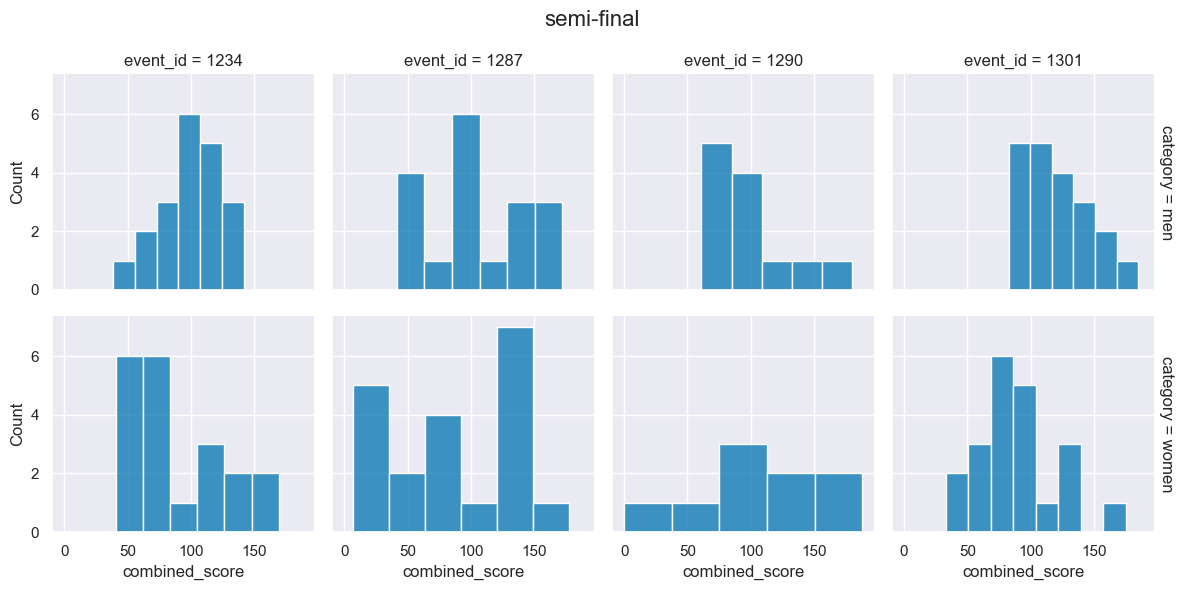

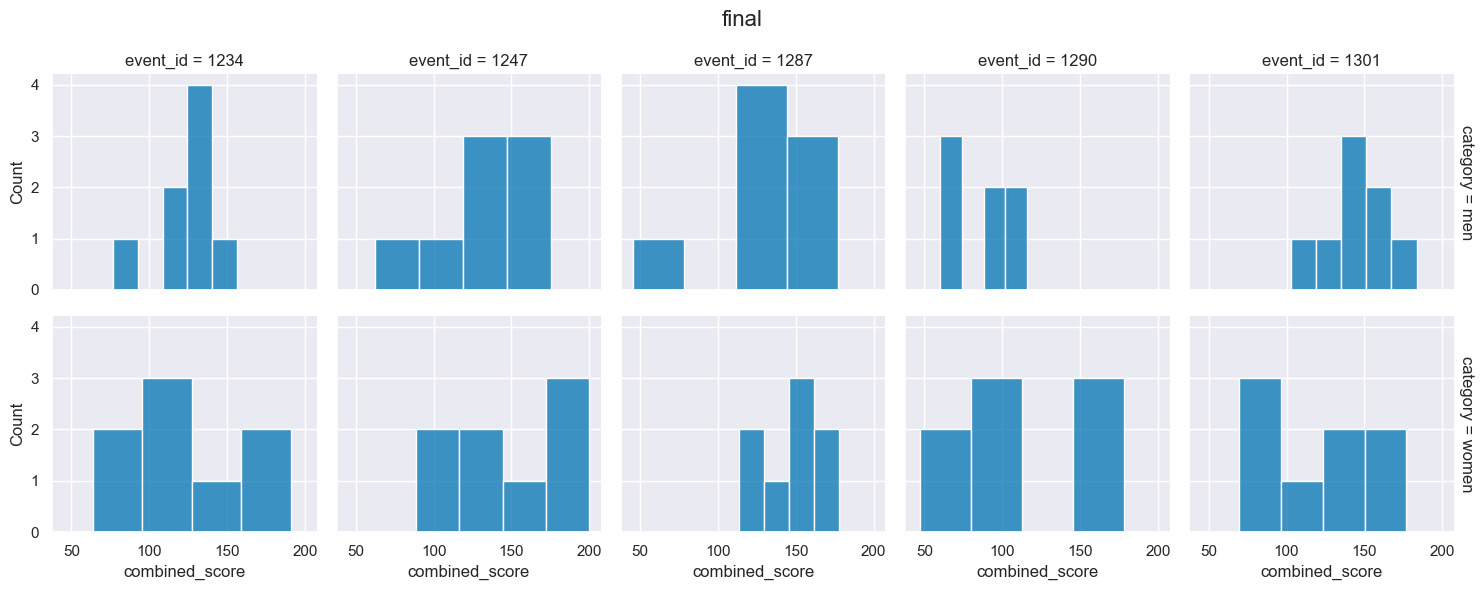

In [504]:
from matplotlib import colors as pltcolors
cleandf.loc[:,'event_id_str'] = cleandf.event_id.astype(str)

sns.set_theme(palette="colorblind")

for stage in ['semi-final', 'final']:
    df = cleandf[cleandf.stage == stage]
    g = sns.FacetGrid(df, col='event_id', row='category', row_order=['men', 'women'], margin_titles=True)
    g.figure.suptitle(stage, size=16)
    g.map(sns.histplot, 'combined_score')                  

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


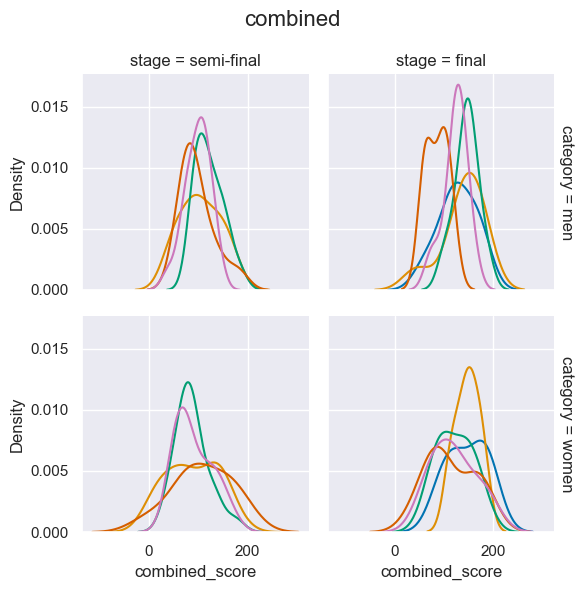

In [516]:

g = sns.FacetGrid(cleandf, col='stage', col_order=['semi-final', 'final'], row='category', row_order=['men', 'women'], margin_titles=True, hue='event_id_str')
g.figure.suptitle('combined', size=16)
g.map(sns.kdeplot, 'combined_score')                  

### Boulder scores

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


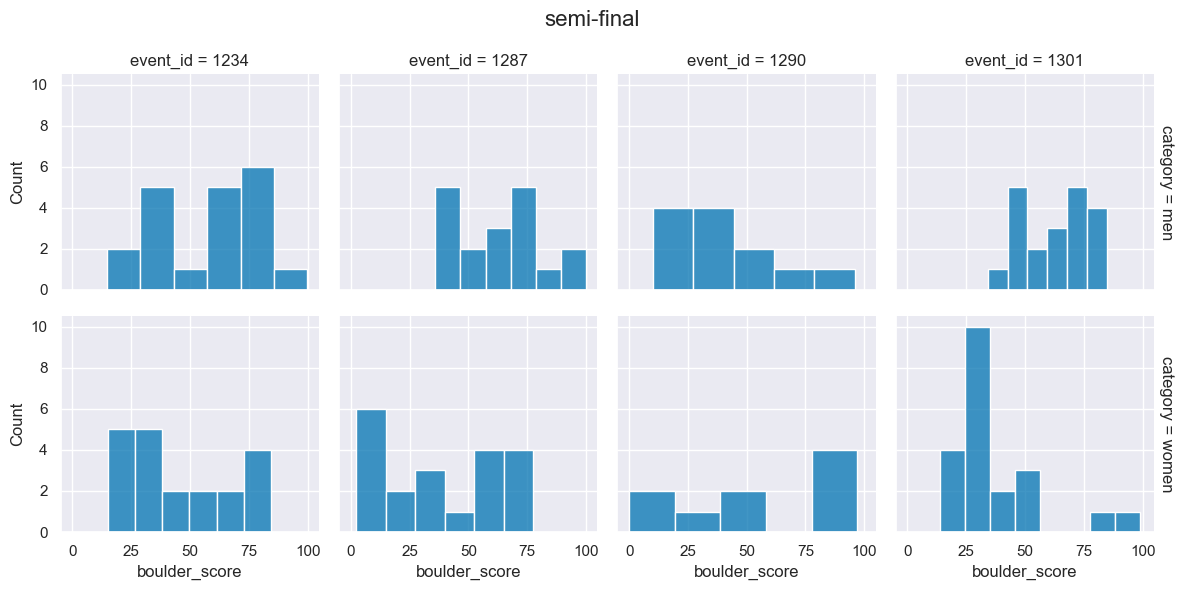

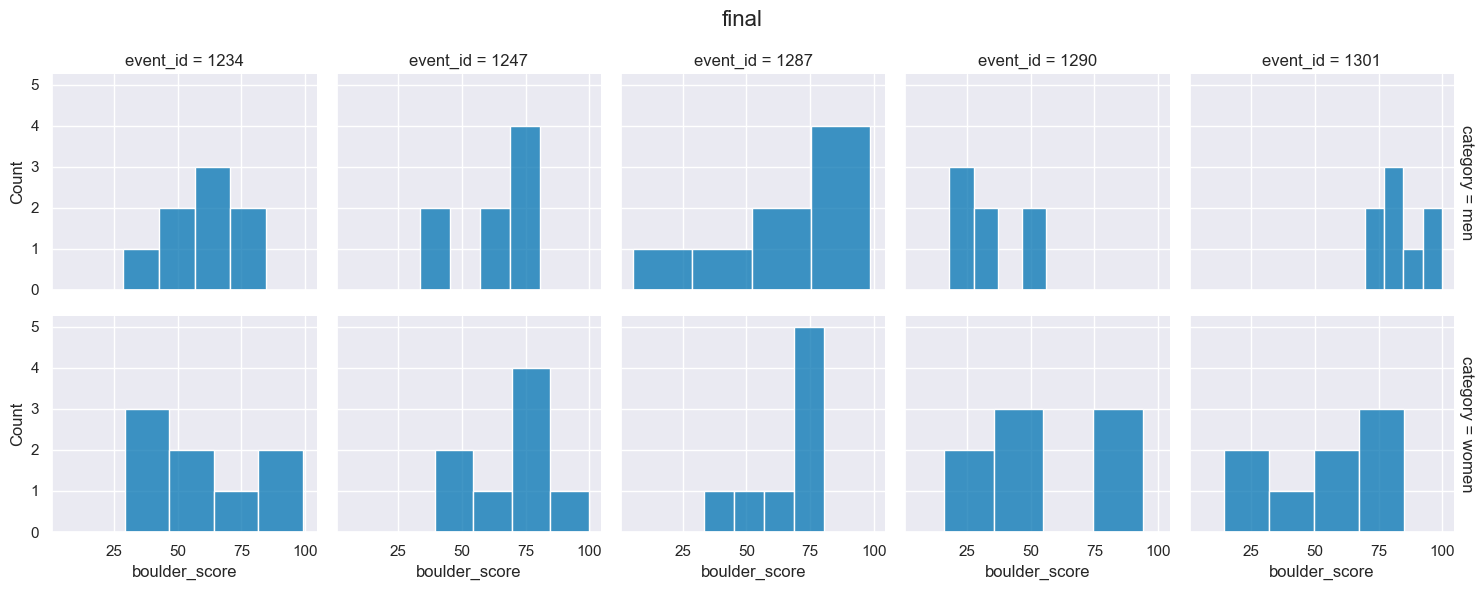

In [507]:
from matplotlib import colors as pltcolors
cleandf.loc[:,'event_id_str'] = cleandf.event_id.astype(str)

sns.set_theme(palette="colorblind")

for stage in ['semi-final', 'final']:
    df = cleandf[cleandf.stage == stage]
    g = sns.FacetGrid(df, col='event_id', row='category', row_order=['men', 'women'], margin_titles=True)
    g.figure.suptitle(stage, size=16)
    g.map(sns.histplot, 'boulder_score')                  

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


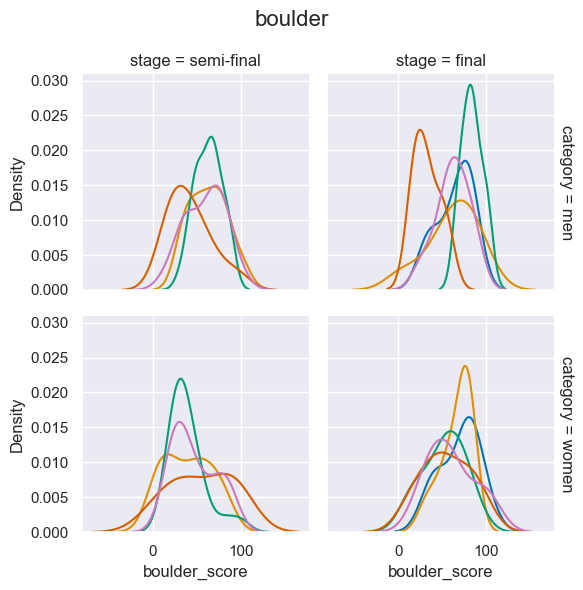

In [515]:

g = sns.FacetGrid(cleandf, col='stage', col_order=['semi-final', 'final'], row='category', row_order=['men', 'women'], margin_titles=True, hue='event_id_str')
g.figure.suptitle('boulder', size=16)
g.map(sns.kdeplot, 'boulder_score')                  

### Lead scores

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


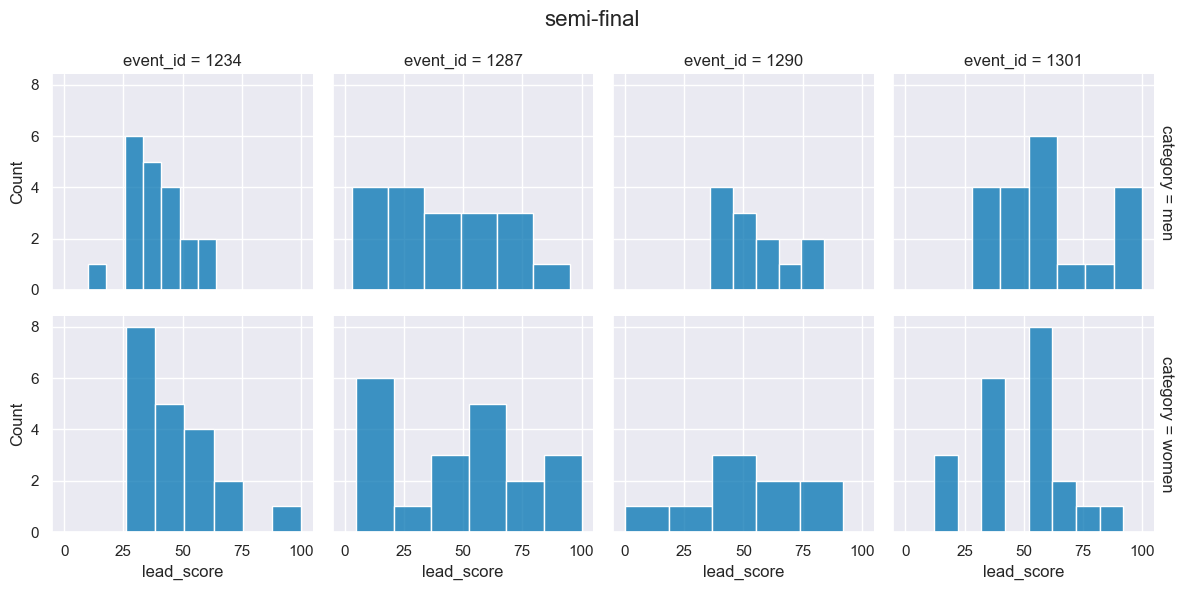

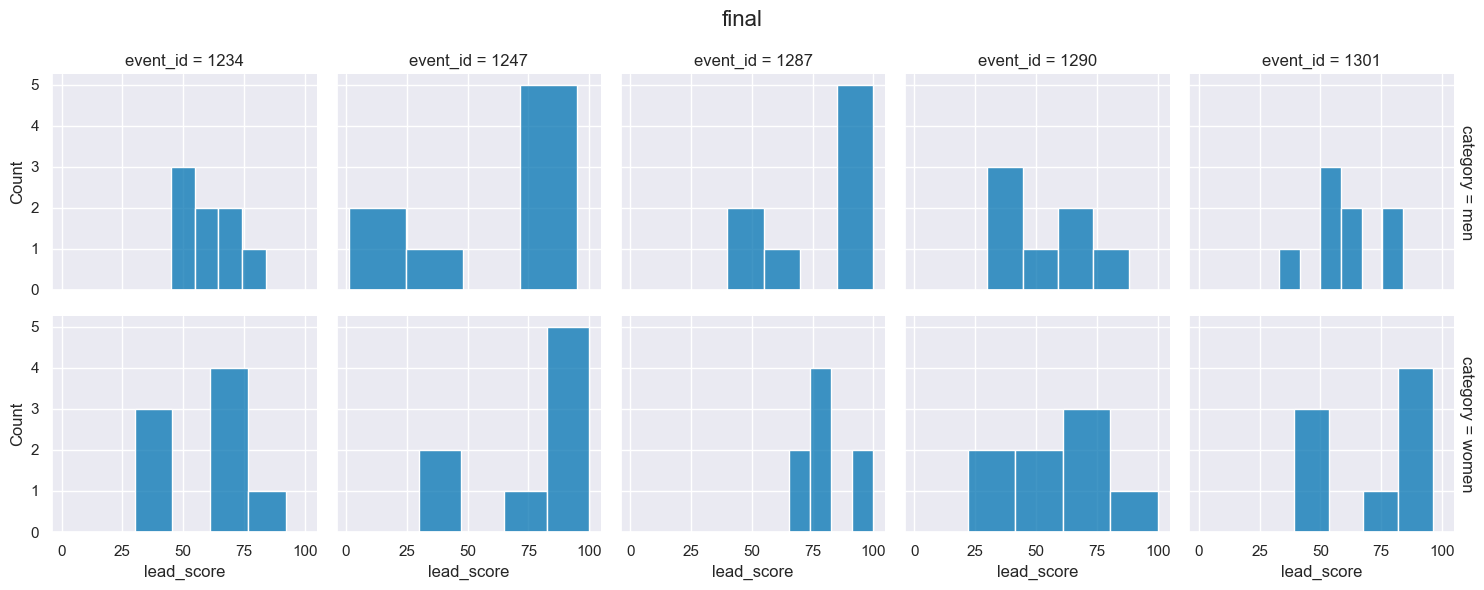

In [512]:
from matplotlib import colors as pltcolors
cleandf.loc[:,'event_id_str'] = cleandf.event_id.astype(str)

sns.set_theme(palette="colorblind")

for stage in ['semi-final', 'final']:
    df = cleandf[cleandf.stage == stage]
    g = sns.FacetGrid(df, col='event_id', row='category', row_order=['men', 'women'], margin_titles=True)
    g.figure.suptitle(stage, size=16)
    g.map(sns.histplot, 'lead_score')                  

/Users/mlauter/development/compclimbingstats/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


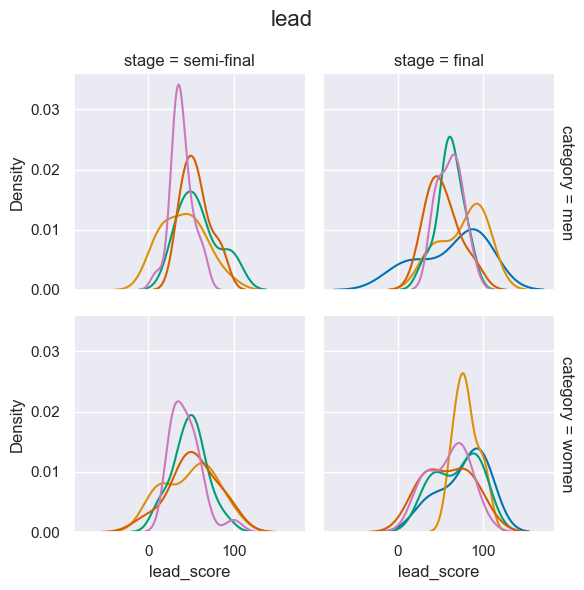

In [514]:

g = sns.FacetGrid(cleandf, col='stage', col_order=['semi-final', 'final'], row='category', row_order=['men', 'women'], margin_titles=True, hue='event_id_str')
g.figure.suptitle('lead', size=16)
g.map(sns.kdeplot, 'lead_score')                  